In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation


In [10]:
from src.modules.data_preprocessing import load_data
import numpy as np
import random
from scipy.special import expit
from scipy import optimize
from sklearn.feature_selection import mutual_info_regression

## MAR

### MAR Sigmoid

In [22]:
def mask_mar_sigmoid(mask, col, data_corr, missing_ratio, missing_func, strict, seed):

    np.random.seed(seed)
    random.seed(seed)
    #################################################################################
    # pick coefficients
    #################################################################################
    # Pick coefficients so that W^Tx has unit variance (avoids shrinking)
    if isinstance(missing_ratio, dict):
        missing_ratio = missing_ratio[col]
    else:
        missing_ratio = missing_ratio

    # copy data and do min-max normalization
    data_copy = data_corr.copy()
    if data_copy.ndim == 1:
        data_copy = data_copy.reshape(-1, 1)
    data_copy = (data_copy - data_copy.min(0, keepdims=True)) / (
        data_copy.max(0, keepdims=True) - data_copy.min(0, keepdims=True))
    data_copy = (data_copy - data_copy.mean(0, keepdims=True)) / \
        data_copy.std(0, keepdims=True)

    coeffs = np.random.rand(data_copy.shape[1], 1)
    Wx = data_copy @ coeffs
    wss = (Wx) / np.std(Wx, 0, keepdims=True)

    def f(x: np.ndarray) -> np.ndarray:
        if missing_func == 'left':
            return expit(-wss + x).mean().item() - missing_ratio
        elif missing_func == 'right':
            return expit(wss + x).mean().item() - missing_ratio
        elif missing_func == 'mid':
            return expit(np.absolute(wss) - 0.75 + x).mean().item() - missing_ratio
        elif missing_func == 'tail':
            return expit(-np.absolute(wss) + 0.75 + x).mean().item() - missing_ratio
        else:
            raise NotImplementedError

    intercept = optimize.bisect(f, -50, 50)

    if missing_func == 'left':
        ps = expit(-wss + intercept)
    elif missing_func == 'right':
        ps = expit(wss + intercept)
    elif missing_func == 'mid':
        ps = expit(-np.absolute(wss) + 0.75 + intercept)
    elif missing_func == 'tail':
        ps = expit(np.absolute(wss) - 0.75 + intercept)
    else:
        raise NotImplementedError

    # strict false means using random simulation
    if strict is False:
        ber = np.random.binomial(n=1, size=mask.shape[0], p=ps.flatten())
        mask[:, col] = ber
    # strict mode based on rank on calculated probability, strictly made missing
    else:
        ps = ps.flatten()
        # print(ps)
        end_value = np.sort(ps)[::-1][int(missing_ratio * data_copy.shape[0])]
        indices = np.where((ps - end_value) > 1e-3)[0]
        if len(indices) < int(missing_ratio * data_copy.shape[0]):
            end_indices = np.where(np.absolute(ps - end_value) <= 1e-3)[0]
            end_indices = np.random.choice(
                end_indices, int(missing_ratio * data_copy.shape[0]) - len(indices), replace=False
            )
            indices = np.concatenate((indices, end_indices))
        elif len(indices) > int(missing_ratio * data_copy.shape[0]):
            indices = np.random.choice(indices, int(
                missing_ratio * data_copy.shape[0]), replace=False)

        mask[indices, col] = True

    return mask

In [11]:
def simulate_nan_mar_sigmoid(data, cols, missing_ratio, missing_func, obs, k, strict=False, seed=1002031):

	mask = np.zeros(data.shape, dtype=bool)

	# add missing for each columns
	for col in cols:

		# set the seed
		seed = (seed + 1203941) % (2 ^ 32 - 1)

		##################################################################################
		# na associated with only observed columns
		if obs is True:
			keep_mask = np.ones(data.shape[1], dtype=bool)
			keep_mask[list(cols)] = False
			X_rest = data[:, keep_mask]
		# na associated with all other columns
		else:
			X_rest = data[:, np.arange(data.shape[1]) != col]

		#################################################################################
		# get k most correlated columns or all columns
		if k == 'all' or k >= X_rest.shape[1]:
			indices_obs = np.arange(data.shape[1])
			indices_obs = np.setdiff1d(indices_obs, np.array(cols))
			data_corr = data[:, indices_obs]
		else:
			score = mutual_info_regression(
				X_rest, data[:, col], discrete_features=False, n_neighbors=5, copy=True, random_state=seed
			)
			indices_obs = np.argsort(score)[::-1][:k]
			data_corr = X_rest[:, indices_obs]

		#################################################################################
		# pick coefficients and mask missing values
		#################################################################################
		mask = mask_mar_sigmoid(mask, col, data_corr, missing_ratio, missing_func, strict, seed)

	# assign the missing values
	data_ms = data.copy()
	data_ms[mask] = np.nan

	return data_ms


def simulate_nan_mary_sigmoid(data, cols, missing_ratio, missing_func, strict=False, seed=1002031):

	mask = np.zeros(data.shape, dtype=bool)

	# add missing for each columns
	for col in cols:

		# set the seed
		seed = (seed + 1203941) % (2 ^ 32 - 1)
		# missing is associated with last column is the target
		indices_obs = [data.shape[1] - 1]
		data_corr = data[:, indices_obs]

		#################################################################################
		# pick coefficients and mask missing values
		#################################################################################
		mask = mask_mar_sigmoid(mask, col, data_corr, missing_ratio, missing_func, strict, seed)

	# assign the missing values
	data_ms = data.copy()
	data_ms[mask] = np.nan

	return data_ms

### MAR Quantile

In [12]:
########################################################################################################################
# mask quantile
###################################################################################################################
def mask_mar_quantile(mask, col, data_corr, missing_ratio, missing_func, strict, seed):

	if strict:
		total_missing = int(missing_ratio * data_corr.shape[0])
		sorted_values = np.sort(data_corr)
		if missing_func == 'left':
			q = sorted_values[int(missing_ratio * data_corr.shape[0]) - 1]
			indices = np.where(data_corr < q)[0]

			if len(indices) < total_missing:
				end_indices = np.where(
					data_corr == q
				)[0]
				add_up_indices = np.random.choice(
					end_indices, size=total_missing - len(indices), replace=False
				)
				na_indices = np.concatenate((indices, add_up_indices))
			elif len(indices) > total_missing:
				na_indices = np.random.choice(
					indices, size=total_missing, replace=False
				)
			else:
				na_indices = indices
		elif missing_func == 'right':
			q = sorted_values[int((1 - missing_ratio) * data_corr.shape[0])]
			indices = np.where(data_corr > q)[0]
			if len(indices) < total_missing:
				start_indices = np.where(
					data_corr == q
				)[0]
				add_up_indices = np.random.choice(
					start_indices, size=total_missing - len(indices), replace=False
				)
				na_indices = np.concatenate((indices, add_up_indices))
			elif len(indices) > total_missing:
				na_indices = np.random.choice(
					indices, size=total_missing, replace=False
				)
			else:
				na_indices = indices
		elif missing_func == 'mid' or missing_func == 'tail':
			q0 = sorted_values[int((1 - missing_ratio) / 2 * data_corr.shape[0])]
			q1 = sorted_values[int((1 + missing_ratio) / 2 * data_corr.shape[0]) - 1]
			if missing_func == 'mid':
				indices = np.where(
					(data_corr > q0) & (data_corr < q1)
				)[0]
			else:
				indices = np.where(
					(data_corr < q0) | (data_corr > q1)
				)[0]
			if len(indices) < total_missing:
				end_indices_q0 = np.where(data_corr == q0)[0]
				end_indices_q1 = np.where(data_corr == q1)[0]
				end_indices = np.union1d(
					end_indices_q0, end_indices_q1
				)
				add_up_indices = np.random.choice(
					end_indices, size=total_missing - len(indices), replace=False
				)
				na_indices = np.concatenate((indices, add_up_indices))
			elif len(indices) > total_missing:
				na_indices = np.random.choice(
					indices, size=total_missing, replace=False
				)
			else:
				na_indices = indices
		else:
			raise NotImplementedError
	else:
		if missing_func == 'left':
			q0 = 0
			q1 = 0.5 if missing_ratio <= 0.5 else missing_ratio
		elif missing_func == 'right':
			q0 = 0.5 if missing_ratio <= 0.5 else 1 - missing_ratio
			q1 = 1
		elif missing_func == 'mid' or missing_func == 'tail':
			q0 = 0.25 if missing_ratio <= 0.5 else 0.5 - missing_ratio / 2
			q1 = 0.75 if missing_ratio <= 0.5 else 0.5 + missing_ratio / 2
		else:
			raise NotImplementedError

		sorted_values = np.sort(data_corr)
		q0 = sorted_values[int(q0 * data_corr.shape[0])]
		q1 = sorted_values[int(q1 * data_corr.shape[0]) - 1]

		if missing_func != 'tail':
			indices = np.where(
				(data_corr >= q0) & (data_corr <= q1)
			)[0]
		else:
			indices = np.where(
				(data_corr <= q0) | (data_corr >= q1)
			)[0]
		np.random.seed(seed)
		na_indices = np.random.choice(
			indices, size=int(missing_ratio * data_corr.shape[0]), replace=False
		)

	mask[na_indices, col] = True

	return mask

In [13]:
import numpy as np
import random
from sklearn.feature_selection import mutual_info_regression
from scipy.special import expit
from scipy import optimize


def simulate_nan_mar_quantile(
		data, cols, missing_ratio, missing_func='left', obs=False, strict=True, seed=201030
):

	# find the columns that are not to be adding missing values
	obs_cols = []
	for index in range(data.shape[1]):
		if index not in cols:
			obs_cols.append(index)
	obs_cols = np.array(obs_cols)
	if obs and len(obs_cols) == 0:
		raise ValueError("No columns to observe, try to set obs to be False")
	
	mask = np.zeros(data.shape, dtype=bool)

	for col in cols:

		if isinstance(missing_ratio, dict):
			missing_ratio = missing_ratio[col]
		else:
			missing_ratio = missing_ratio

		# set the seed
		seed = (seed + 10087651) % (2 ** 32 - 1)
		random.seed(seed)
		np.random.seed(seed)

		# find the most correlated column
		if obs:
			X_rest = data[:, obs_cols]
		else:
			X_rest = data[:, np.arange(data.shape[1]) != col]

		score = mutual_info_regression(
			X_rest, data[:, col], discrete_features=False, n_neighbors=5, copy=True, random_state=seed
		)
		most_correlated_col_idx = np.argmax(score)
		data_corr = X_rest[:, most_correlated_col_idx]

		# find the quantile of the most correlated column
		if missing_func == 'random':
			missing_func = random.choice(['left', 'right', 'mid', 'tail'])
	
		# get mask based on quantile
		mask = mask_mar_quantile(mask, col, data_corr, missing_ratio, missing_func, strict, seed)

	# assign the missing values
	data_ms = data.copy()
	data_ms[mask] = np.nan

	return data_ms


def simulate_nan_mary_quantile(
		data, cols, missing_ratio, missing_func='left', strict=True, seed=201030
):
	
	# find the columns that are not to be adding missing values
	mask = np.zeros(data.shape, dtype=bool)

	for col in cols:

		if isinstance(missing_ratio, dict):
			missing_ratio = missing_ratio[col]
		else:
			missing_ratio = missing_ratio

		# set the seed
		seed = (seed + 10087651) % (2 ** 32 - 1)
		random.seed(seed)
		np.random.seed(seed)
	
		most_correlated_col_idx = data.shape[1] - 1
		data_corr = data[:, most_correlated_col_idx]

		# find the quantile of the most correlated column
		if missing_func == 'random':
			missing_func = random.choice(['left', 'right', 'mid', 'tail'])
	
		# get mask based on quantile
		mask = mask_mar_quantile(mask, col, data_corr, missing_ratio, missing_func, strict, seed)

	# assign the missing values
	data_ms = data.copy()
	data_ms[mask] = np.nan

	return data_ms

## MNAR

### MNAR Quantile

In [48]:
def simulate_nan_mnar_quantile(
		data, cols, missing_ratio, missing_func='left', strict=True, seed=201030
):
	
	# find the columns that are not to be adding missing values
	mask = np.zeros(data.shape, dtype=bool)

	for col in cols:

		if isinstance(missing_ratio, dict):
			missing_ratio = missing_ratio[col]
		else:
			missing_ratio = missing_ratio

		# set the seed
		seed = (seed + 10087651) % (2 ** 32 - 1)
		random.seed(seed)
		np.random.seed(seed)
		
		data_corr = data[:, col]

		# find the quantile of the most correlated column
		if missing_func == 'random':
			missing_func = random.choice(['left', 'right', 'mid', 'tail'])
	
		# get mask based on quantile
		mask = mask_mar_quantile(mask, col, data_corr, missing_ratio, missing_func, strict, seed)

	# assign the missing values
	data_ms = data.copy()
	data_ms[mask] = np.nan

	return data_ms

### MNAR Sigmoid

In [14]:
def simulate_nan_mnar_sigmoid(data, cols, missing_ratio, missing_func, strict=False, seed=1002031):

	mask = np.zeros(data.shape, dtype=bool)

	# add missing for each columns
	for col in cols:

		# set the seed
		seed = (seed + 1203941) % (2 ^ 32 - 1)
		# missing is associated with column itself
		data_corr = data[:, col]

		#################################################################################
		# pick coefficients and mask missing values
		#################################################################################
		mask = mask_mar_sigmoid(mask, col, data_corr, missing_ratio, missing_func, strict, seed)

	# assign the missing values
	data_ms = data.copy()
	data_ms[mask] = np.nan

	return data_ms

### Test

In [28]:
data, config = load_data('iris')

<AxesSubplot: >

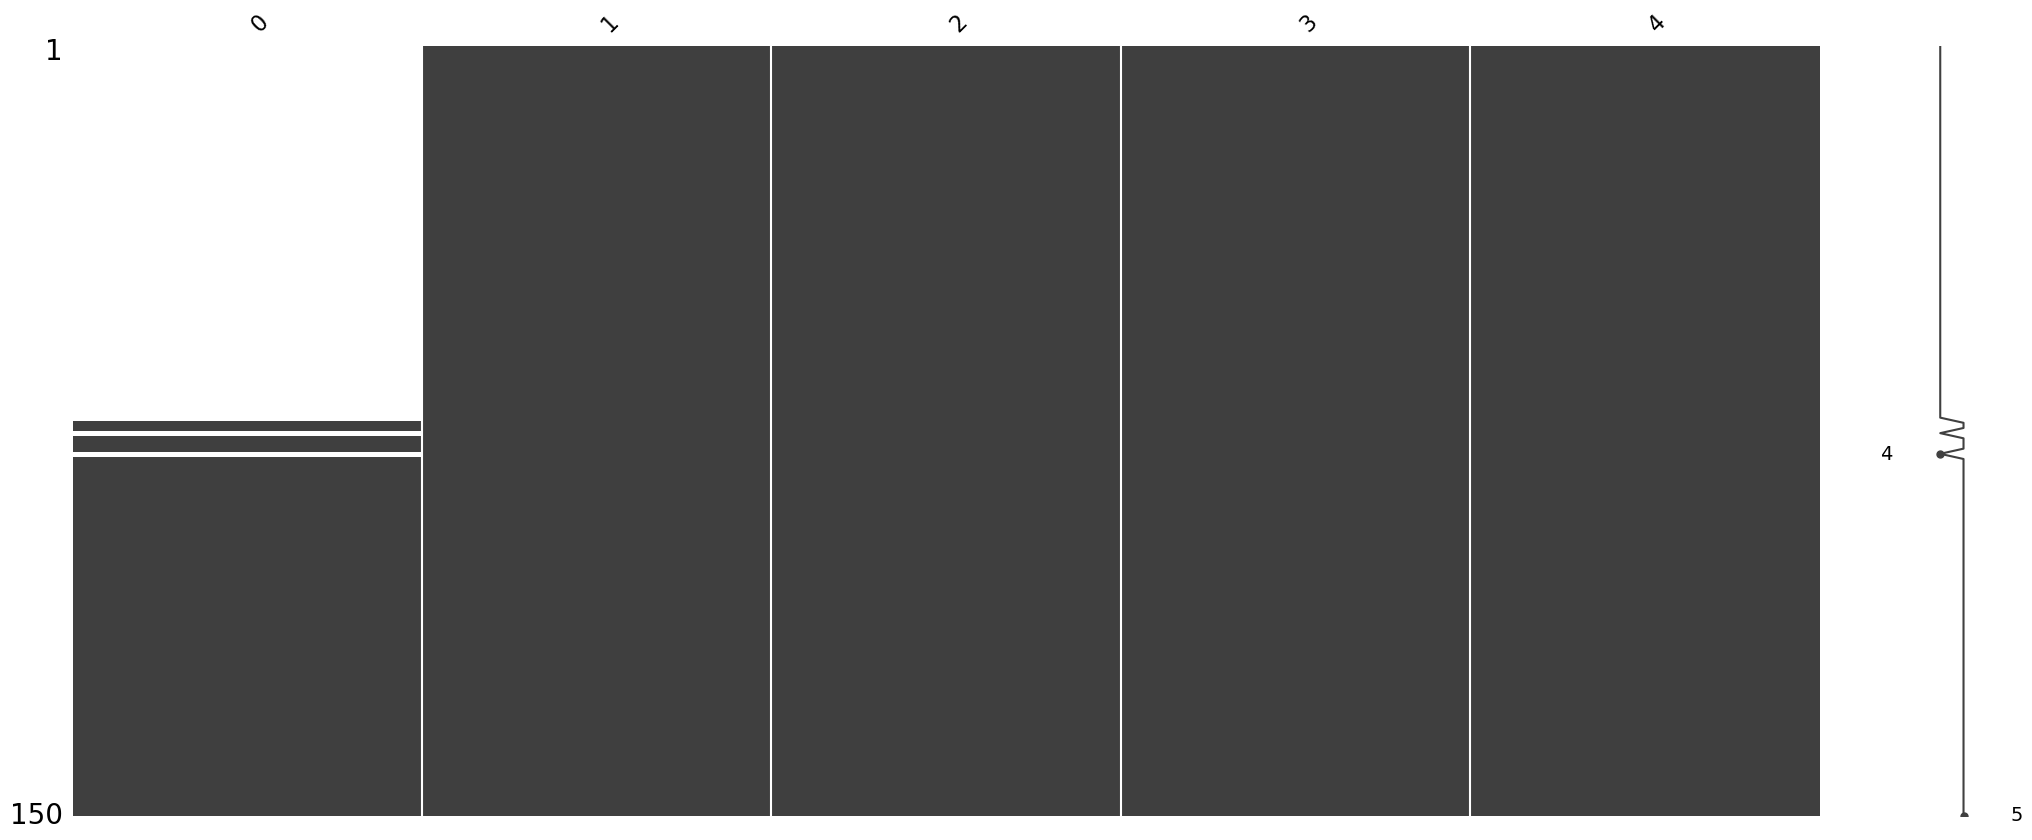

In [46]:
cols = [0]
col_names = [data.columns[i] for i in cols]
data = data.sort_values(by = col_names, ascending = True)
data_ms = simulate_nan_mnar_sigmoid(data.values, cols = cols, missing_ratio=0.5, missing_func='left', strict=True, seed=1002031)

import missingno as msno
import pandas as pd

msno.matrix(pd.DataFrame(data_ms))

<AxesSubplot: >

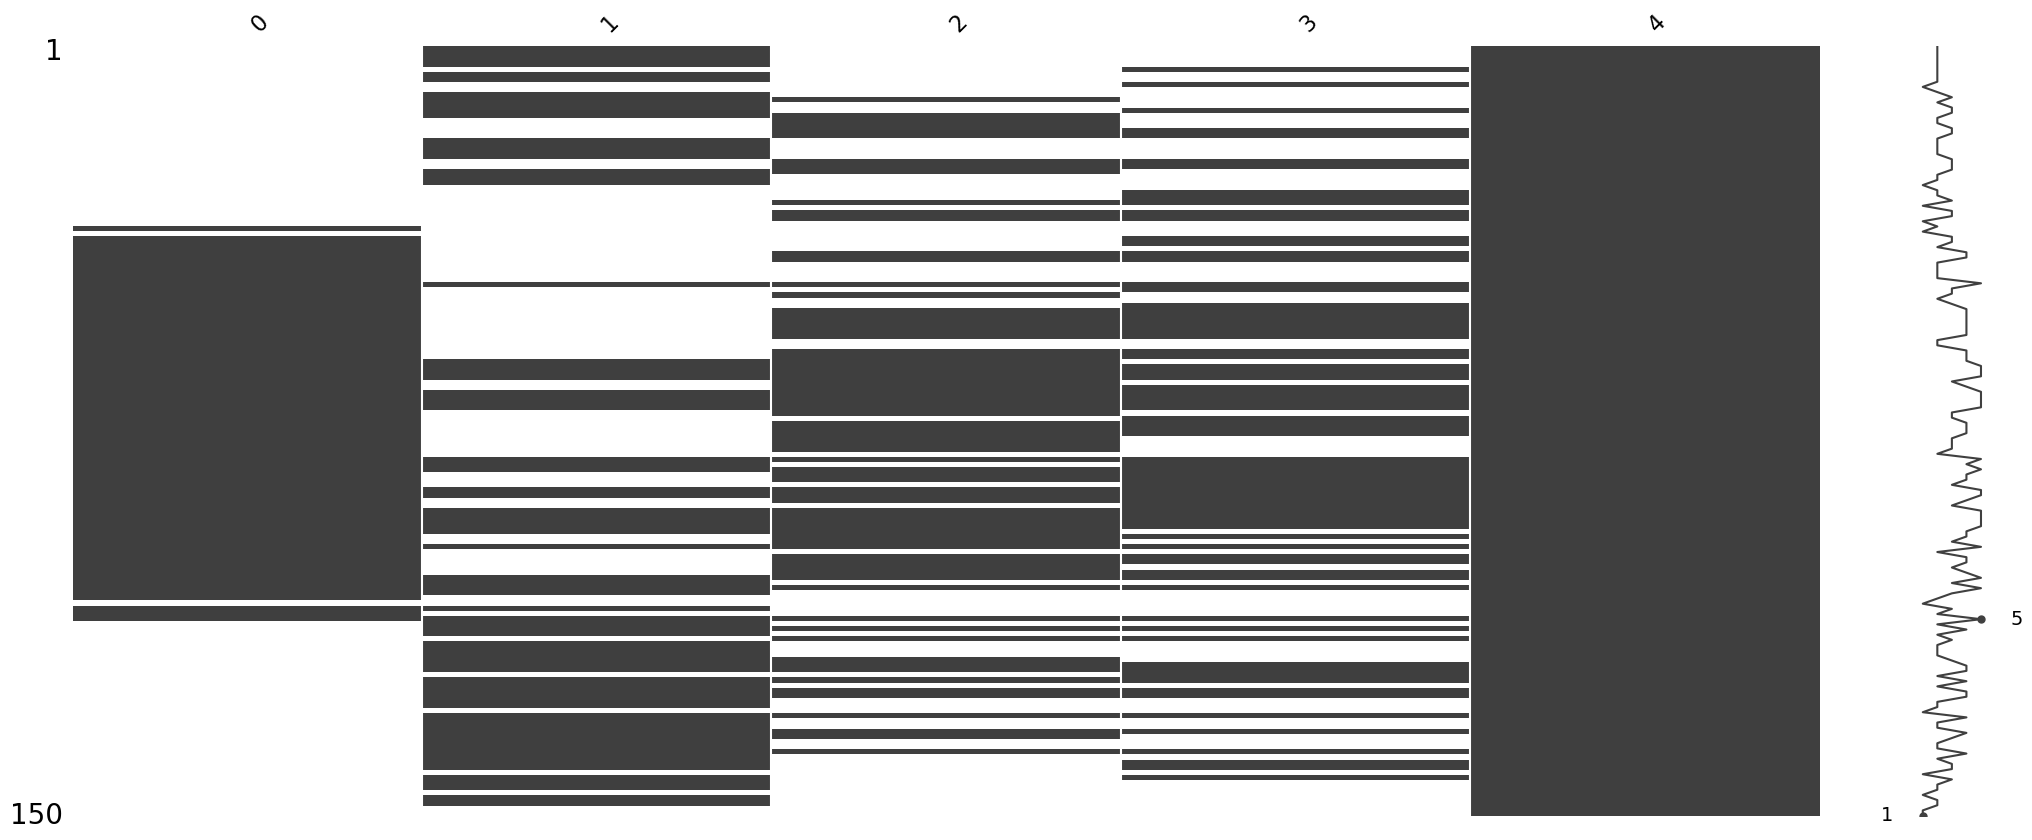

In [58]:
cols = [0, 1, 2, 3]
col_names = [data.columns[i] for i in cols]
data = data.sort_values(by = col_names, ascending = True)
data_ms = simulate_nan_mnar_quantile(data.values, cols = cols, missing_ratio=0.5, missing_func='tail', strict=True, seed=1002031)

import missingno as msno
import pandas as pd

msno.matrix(pd.DataFrame(data_ms))